In [1]:
#my modules
from bass_lv_v2 import SVBassLV
from heston import Heston, implied_vol
from utils import Density, mc_iv, bs_call_price
from reference_models import BrownianMotion_R
from reference_models import ArithmeticSABR_R

#modules
from math import *
import numpy as np
import matplotlib.pyplot as plt

### Bass model based on the Brownian motion 

In [2]:
#create the market marginals as an objects with functions from Heston model
model = Heston(s0 = 100, v0 = 0.1, kappa = 2, theta = 0.07, xi = 1, rho = -0.7)
T = [0.25, 0.7, 1]
market_marginal_1 = Density(model.cdf_interpolate(0.25), model.quantile_interpolate(0.25))
market_marginal_2 = Density(model.cdf_interpolate(0.7), model.quantile_interpolate(0.7))
market_marginal_3 = Density(model.cdf_interpolate(1), model.quantile_interpolate(1))

In [3]:
#Create a reference model, which is a Brownian motion in our case
ref_bm = BrownianMotion_R(100, 1)
bass_bm = SVBassLV(100, ref_bm, {0.25: market_marginal_1, 0.7: market_marginal_2, 1: market_marginal_3})

#calibration example for the Heston market marginals
res = bass_bm.calibrate(tolerance = 0.001, max_iter = 100, N = 10_000, nsigma = 5)

Interval 1 (T=0.7): 5 iterations, final error = 0.000617741663929805
Interval 2 (T=1.0): 13 iterations, final error = 0.0008089380806213242


In [5]:
#Simulation of contineous paths
final_paths, xi_paths = bass_bm.simulate_paths(1_000_000, 100)

epsilon = 0.05      #changed from 0.01 to a bigger value

xi_paths_plus_eps = [p + epsilon for p in xi_paths]
xi_paths_minus_eps = [p - epsilon for p in xi_paths]

St_0_plus_eps = bass_bm.data[0].brenier_map(xi_paths_plus_eps[0][:,-1])
St_0_minus_eps = bass_bm.data[0].brenier_map(xi_paths_minus_eps[0][:,-1])

St_1_plus_eps = bass_bm.data[1].brenier_map(xi_paths_plus_eps[1][:,-1])
St_1_minus_eps = bass_bm.data[1].brenier_map(xi_paths_minus_eps[1][:,-1])

St_2_plus_eps = bass_bm.data[2].brenier_map(xi_paths_plus_eps[2][:,-1])
St_2_minus_eps = bass_bm.data[2].brenier_map(xi_paths_minus_eps[2][:,-1])

steps split between maturities = [25, 45, 30]
time interval = 0.25
time interval = 0.44999999999999996
time interval = 0.30000000000000004


In [6]:
# We need to recalculate the initial price after shifting xi-paths
#it is done by plugging the starting point of Brownian motion to the function: f_0(x) - stretching function at the first point
stretching_function_0 = bass_bm.create_stretching_function(0, 0.25, 'direct')

s0_plus_eps = stretching_function_0(100 + 0.05)
s0_minus_eps = stretching_function_0(100 - 0.05)

print(s0_plus_eps, s0_minus_eps)

101.38499928726785 98.57793450260026


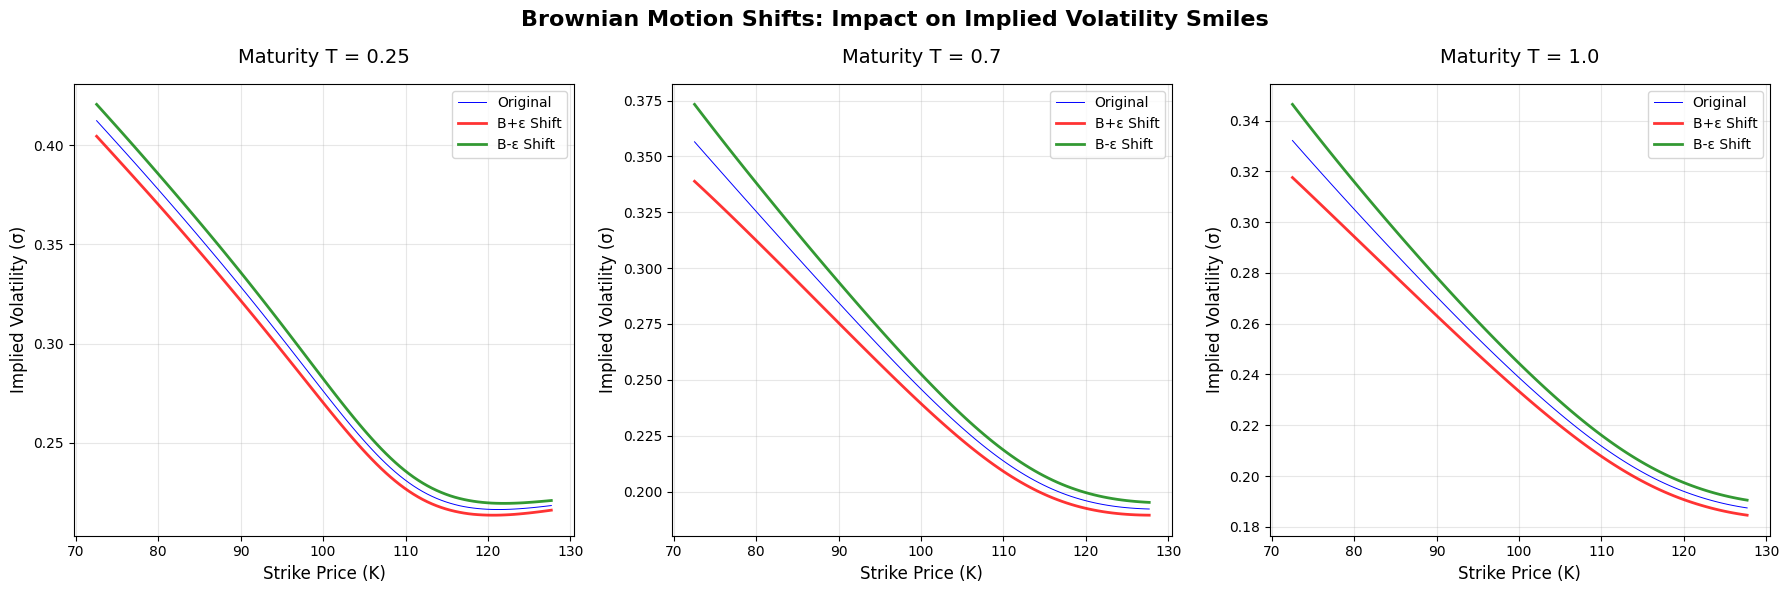

In [7]:
#plotting
K = np.linspace(market_marginal_1.qf(0.05), market_marginal_1.qf(0.99), 100)

fig = plt.figure(figsize=(18, 6))

# Add 3 subplots in a row
ax1 = fig.add_subplot(131)  # 1 row, 3 columns, 1st position
ax2 = fig.add_subplot(132)  # 1 row, 3 columns, 2nd position
ax3 = fig.add_subplot(133)  # 1 row, 3 columns, 3rd position

# Plot 1: T = 0.25
ax1.plot(K, mc_iv(model.s0, 0.25, K, final_paths[0][:,-1]), 'b', linewidth=0.7, alpha=1, label='Original')
ax1.plot(K, mc_iv(s0_plus_eps, 0.25, K, St_0_plus_eps), 'r-', linewidth=2, alpha=0.8, label='B+ε Shift')
ax1.plot(K, mc_iv(s0_minus_eps, 0.25, K, St_0_minus_eps), 'g-', linewidth=2, alpha=0.8, label='B-ε Shift')
ax1.set_title('Maturity T = 0.25', fontsize=14, pad=15)
ax1.set_xlabel('Strike Price (K)', fontsize=12, )
ax1.set_ylabel('Implied Volatility (σ)', fontsize=12, )
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=10)

# Plot 2: T = 0.7
ax2.plot(K, mc_iv(model.s0, 0.7, K, final_paths[1][:,-1]), 'b', linewidth=0.7, alpha=1, label='Original')
ax2.plot(K, mc_iv(s0_plus_eps, 0.7, K, St_1_plus_eps), 'r-', linewidth=2, alpha=0.8, label='B+ε Shift')
ax2.plot(K, mc_iv(s0_minus_eps, 0.7, K, St_1_minus_eps), 'g-', linewidth=2, alpha=0.8, label='B-ε Shift')
ax2.set_title('Maturity T = 0.7', fontsize=14, pad=15)
ax2.set_xlabel('Strike Price (K)', fontsize=12)
ax2.set_ylabel('Implied Volatility (σ)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', which='major', labelsize=10)

# Plot 3: T = 1.0
ax3.plot(K, mc_iv(model.s0, 1, K, final_paths[2][:,-1]), 'b', linewidth=0.7, alpha=1, label='Original')
ax3.plot(K, mc_iv(s0_plus_eps, 1, K, St_2_plus_eps), 'r-', linewidth=2, alpha=0.8, label='B+ε Shift')
ax3.plot(K, mc_iv(s0_minus_eps, 1, K, St_2_minus_eps), 'g-', linewidth=2, alpha=0.8, label='B-ε Shift')
ax3.set_title('Maturity T = 1.0', fontsize=14, pad=15)
ax3.set_xlabel('Strike Price (K)', fontsize=12)
ax3.set_ylabel('Implied Volatility (σ)', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='both', which='major', labelsize=10)

# Add overall title
fig.suptitle('Brownian Motion Shifts: Impact on Implied Volatility Smiles', 
             fontsize=16, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout()
plt.show()

### Bass model based on the Arithmetic SABR model

In [8]:
#Create a reference model, which is a Brownian motion in our case
ref_sv = ArithmeticSABR_R(100, 1, -0.6, 0.7)
bass_sabr = SVBassLV(100, ref_sv, {0.25: market_marginal_1, 0.7: market_marginal_2, 1: market_marginal_3})

#calibration example for the Heston market marginals
res = bass_sabr.calibrate(tolerance = 0.001, max_iter = 100, N = 10_000, nsigma = 5)

Interval 1 (T=0.7): 99 iterations, final error = 0.003982001980437855
Interval 2 (T=1.0): 14 iterations, final error = 0.0009460870884058226


In [10]:
#Simulation of contineous paths
final_paths, xi_paths = bass_sabr.simulate_paths(1_000_000, 100)

epsilon = 0.05 # changed from 0.01 to a bigger value

xi_paths_plus_eps = [p + epsilon for p in xi_paths]
xi_paths_minus_eps = [p - epsilon for p in xi_paths]

St_0_plus_eps = bass_sabr.data[0].brenier_map(xi_paths_plus_eps[0][:,-1])
St_0_minus_eps = bass_sabr.data[0].brenier_map(xi_paths_minus_eps[0][:,-1])

St_1_plus_eps = bass_sabr.data[1].brenier_map(xi_paths_plus_eps[1][:,-1])
St_1_minus_eps = bass_sabr.data[1].brenier_map(xi_paths_minus_eps[1][:,-1])

St_2_plus_eps = bass_sabr.data[2].brenier_map(xi_paths_plus_eps[2][:,-1])
St_2_minus_eps = bass_sabr.data[2].brenier_map(xi_paths_minus_eps[2][:,-1])

steps split between maturities = [25, 45, 30]
time interval = 0.25
time interval = 0.44999999999999996
time interval = 0.30000000000000004


In [11]:
# We need to recalculate the initial price after shifting xi-paths

#it is done by plugging the starting point of Brownian motion to the function:
#f_0(x) - stretching function at the first point
stretching_function_0 = bass_sabr.create_stretching_function(0, 0.25, 'direct')
s0_plus_eps = stretching_function_0(100 + 0.05)
s0_minus_eps = stretching_function_0(100 - 0.05)

print(s0_plus_eps, s0_minus_eps)

101.52424929788737 98.6979507129594


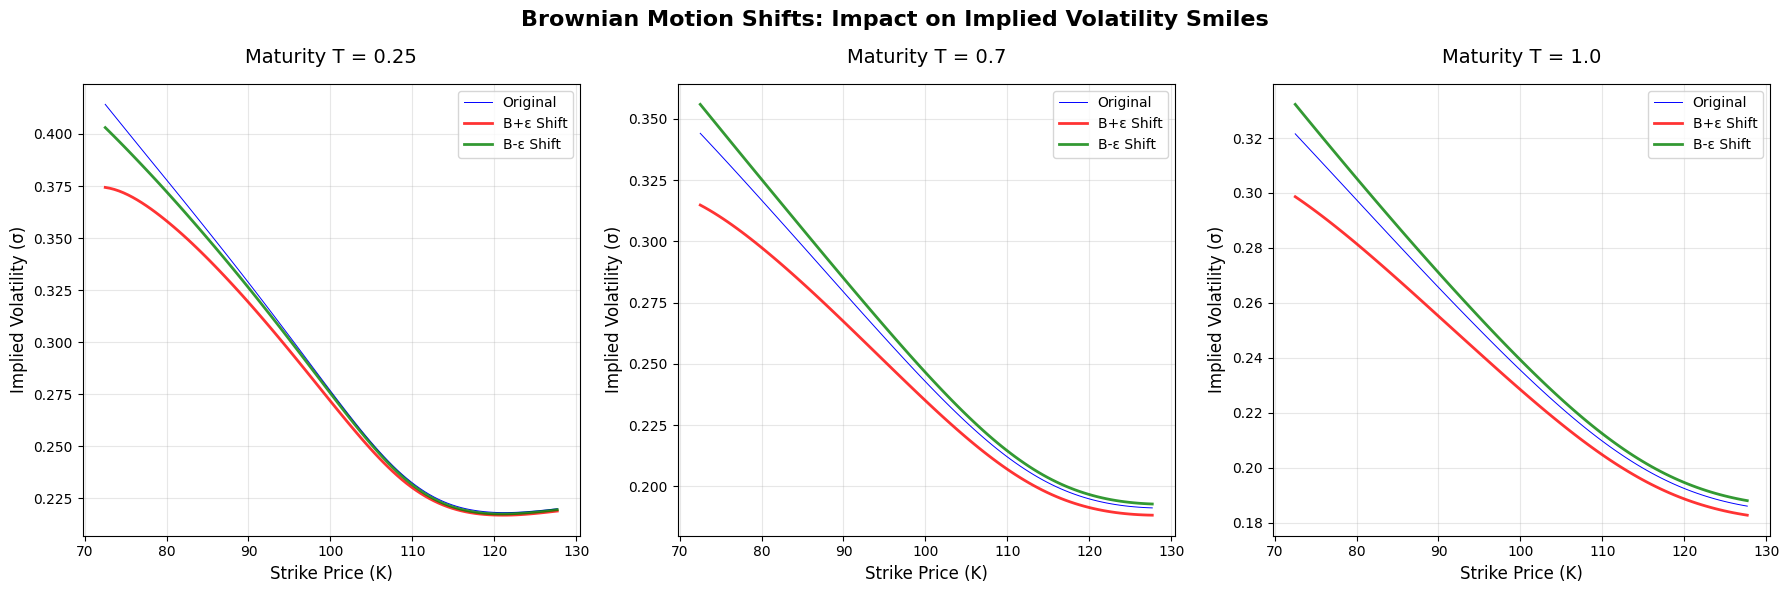

In [ ]:
#plotting
K = np.linspace(market_marginal_1.qf(0.05), market_marginal_1.qf(0.99), 100)

fig = plt.figure(figsize=(18, 6))

# Add 3 subplots in a row
ax1 = fig.add_subplot(131)  # 1 row, 3 columns, 1st position
ax2 = fig.add_subplot(132)  # 1 row, 3 columns, 2nd position
ax3 = fig.add_subplot(133)  # 1 row, 3 columns, 3rd position

# Plot 1: T = 0.25
ax1.plot(K, mc_iv(model.s0, 0.25, K, final_paths[0][:,-1]), 'b', linewidth=0.7, alpha=1, label='Original')
ax1.plot(K, mc_iv(s0_plus_eps, 0.25, K, St_0_plus_eps), 'r-', linewidth=2, alpha=0.8, label='B+ε Shift')
ax1.plot(K, mc_iv(s0_minus_eps, 0.25, K, St_0_minus_eps), 'g-', linewidth=2, alpha=0.8, label='B-ε Shift')
ax1.set_title('Maturity T = 0.25', fontsize=14, pad=15)
ax1.set_xlabel('Strike Price (K)', fontsize=12, )
ax1.set_ylabel('Implied Volatility (σ)', fontsize=12, )
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=10)

# Plot 2: T = 0.7
ax2.plot(K, mc_iv(model.s0, 0.7, K, final_paths[1][:,-1]), 'b', linewidth=0.7, alpha=1, label='Original')
ax2.plot(K, mc_iv(s0_plus_eps, 0.7, K, St_1_plus_eps), 'r-', linewidth=2, alpha=0.8, label='B+ε Shift')
ax2.plot(K, mc_iv(s0_minus_eps, 0.7, K, St_1_minus_eps), 'g-', linewidth=2, alpha=0.8, label='B-ε Shift')
ax2.set_title('Maturity T = 0.7', fontsize=14, pad=15)
ax2.set_xlabel('Strike Price (K)', fontsize=12)
ax2.set_ylabel('Implied Volatility (σ)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', which='major', labelsize=10)

# Plot 3: T = 1.0
ax3.plot(K, mc_iv(model.s0, 1, K, final_paths[2][:,-1]), 'b', linewidth=0.7, alpha=1, label='Original')
ax3.plot(K, mc_iv(s0_plus_eps, 1, K, St_2_plus_eps), 'r-', linewidth=2, alpha=0.8, label='B+ε Shift')
ax3.plot(K, mc_iv(s0_minus_eps, 1, K, St_2_minus_eps), 'g-', linewidth=2, alpha=0.8, label='B-ε Shift')
ax3.set_title('Maturity T = 1.0', fontsize=14, pad=15)
ax3.set_xlabel('Strike Price (K)', fontsize=12)
ax3.set_ylabel('Implied Volatility (σ)', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='both', which='major', labelsize=10)

# Add overall title
fig.suptitle('Brownian Motion Shifts: Impact on Implied Volatility Smiles', 
             fontsize=16, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout()
plt.show()